In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm, trange

import torch
from torch import optim
from torch import nn

import torchvision

%matplotlib inline

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!nvidia-smi

Fri Aug 13 08:18:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Experiment config

In [ ]:
class DotDict(dict):
    def __getattr__(self, attr): return self.get(attr)
    def __setattr__(self, key, value): self.__setitem__(key, value)
 
config = DotDict()
config.offset = 8
config.pano_size=224
config.crit = 'mae'
config.res = 32
config.batch_size = 8
config.ds_size = 10000
config.ds_val = 1000
config.epochs = 15
config.lr = 2e-4

# Generate synthetic dataset

## Training will be performed on small individual patches
Dots, crosses and noise were tested, crosses with noise were chosen as the most interesting option.

In [ ]:
def generate_dots(N=10000, n_min=5, n_max=15, res=32):
    labels = []
    images = []
    for i in range(N):
        l = np.random.randint(n_min, n_max)
        dots = np.random.randint(0, res, size=(l,2))
        dots = list(map(tuple, dots))
        img = Image.new('RGB', size=(res,res))
        drw = ImageDraw.Draw(img)
        drw.point(dots)
        labels.append(l)
        images.append(torch.FloatTensor(np.array(img)).permute(2, 0, 1) / 255)
    return images, torch.FloatTensor(labels)

In [ ]:
from itertools import chain

def generate_crosses(N=10000, n_min=5, n_max=15, res=32):
    labels = []
    images = []
    for i in range(N):
        l = np.random.randint(n_min, n_max)
        dots = np.random.randint(1, res-1, size=(l,2))
        crosses = [ ((*d,), (d[0]-1, d[1]), (d[0], d[1]-1), (d[0]+1, d[1]), (d[0], d[1]+1)) for d in dots]
        crosses = list(chain.from_iterable(crosses))
        img = Image.new('RGB', size=(res,res))
        drw = ImageDraw.Draw(img)
        drw.point(crosses)
        labels.append(l)
        images.append(torch.FloatTensor(np.array(img)).permute(2, 0, 1) / 255)
    return images, torch.FloatTensor(labels)

In [ ]:
def noisebg(size, k=1.3):
    img = Image.new('RGB', size=(size,size))
    img = np.array(img)
    img += np.random.normal(loc=127, scale=k*127/3, size=(size,size,3)).astype(np.uint8)
    img = img.clip(0, 255)
    img = Image.fromarray(img)
    return img

In [ ]:
def generate_crosses_noisebg(N=10000, n_min=0, n_max=25, res=32):
    labels = []
    images = []
    for i in range(N):
        l = np.random.randint(n_min, n_max)
        dots = np.random.randint(1, res-1, size=(l,2))
        crosses = [ ((*d,), (d[0]-1, d[1]), (d[0], d[1]-1), (d[0]+1, d[1]), (d[0], d[1]+1)) for d in dots]
        crosses = list(chain.from_iterable(crosses))
        img = noisebg(32)
        drw = ImageDraw.Draw(img)
        drw.point(crosses)
        labels.append(l)
        images.append(torch.FloatTensor(np.array(img)).permute(2, 0, 1) / 255)
    return images, torch.FloatTensor(labels)

In [ ]:
generate = generate_crosses_noisebg
images, labels = generate(config.ds_val)

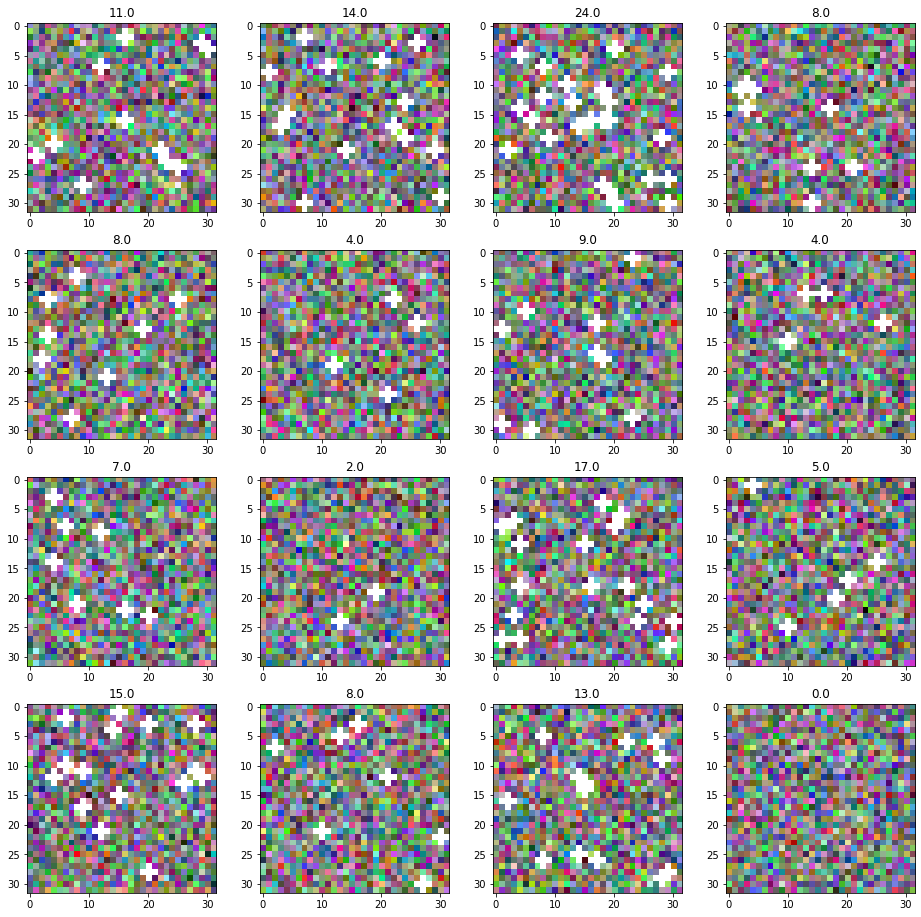

In [ ]:
plt.figure(figsize=(16,16))
for i in range(16):
    s = np.random.choice(len(images))
    plt.subplot(4,4,1+i)
    plt.imshow(images[s].permute(1,2,0))
    plt.title(labels[s].item())

## Panoramic image will be used for model validation



In [ ]:
def generate_pano(size=config.pano_size, offset=config.offset, tilesize=config.res, min_per_tile=5, max_per_tile=8):
    margin = tilesize-offset
    eff_size = size - 2 * margin

    n_min = eff_size**2 * min_per_tile / tilesize**2
    n_max = eff_size**2 * max_per_tile / tilesize**2
    
    l = np.random.randint(n_min, n_max)
    dots = np.random.randint(margin, size-margin, size=(l,2))
    crosses = [ ((*d,), (d[0]-1, d[1]), (d[0], d[1]-1), (d[0]+1, d[1]), (d[0], d[1]+1)) for d in dots]
    crosses = list(chain.from_iterable(crosses))
    img = noisebg(size)
    drw = ImageDraw.Draw(img)
    drw.point(crosses)
    img = torch.FloatTensor(np.array(img)).permute(2, 0, 1) / 255

    return img, l

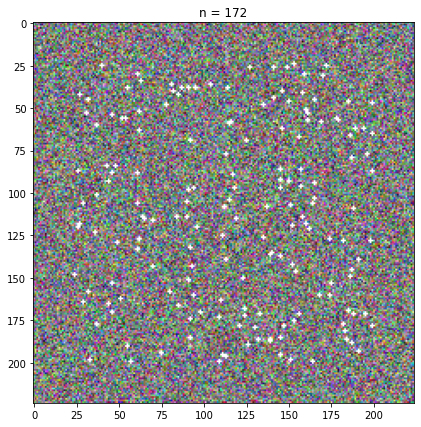

In [ ]:
pano, n = generate_pano()
plt.figure(figsize=(7,7))
plt.imshow(pano.permute(1, 2, 0))
plt.title(f'n = {n}')
plt.show()

## Sliding window heatmap

Prediction heatmap is generated by using the sliding window technique. Each pixel contains stacked predicted count per different windows. 

I get the final prediction by integrating the heatmap.


In [ ]:
def heatmap(img, model, offset=config.offset, winsize=config.res):
    """
    Build a heatmap by sliding a window of winsize**2 pixels over the image
    """
    size = img.size(1)
    predmap = np.zeros((size,size))

    img = img.to(device)
    model = model.to(device)
    model.eval()

    for yoff in range(0, size, offset):
        for xoff in range(0, size, offset):
            
            with torch.no_grad():
                pred = model(img[:, yoff:winsize+yoff, xoff:winsize+xoff]
                            .unsqueeze(0)).item()
            pred /= winsize**2
            predmap[yoff:winsize+yoff, xoff:winsize+xoff] += pred
    predmap *= (offset / winsize)**2
    model.cpu()

    return predmap[winsize-offset:size-winsize+offset, winsize-offset:size-winsize+offset]

In [ ]:
def visualize_heatmap(model, corrective=0, winsize=config.res, offset=config.offset, size=config.pano_size):
    pano, l = generate_pano()
    hmap = heatmap(pano, model, offset)

    plt.figure(figsize=(14,7))
    plt.subplot(121)
    plt.imshow(pano[:, winsize-offset:size-winsize+offset, winsize-offset:size-winsize+offset].permute(1,2,0))
    plt.title(f'{l}')

    plt.subplot(122)
    plt.imshow(hmap)
    plt.title(f'{hmap.sum() + corrective}')
    plt.show()

# Data setup

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DotDS(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, i):
        return self.images[i], self.labels[i]

In [ ]:
dl_train = DataLoader(DotDS(*generate(config.ds_size)), batch_size=config.batch_size, drop_last=True)
dl_val = DataLoader(DotDS(images, labels), batch_size=config.batch_size, drop_last=True)

# Training and scoring


In [ ]:
def score(model):
    """
    Score model using Mean Absolute Error (MAE)
    """
    ae = 0
    model = model.to(device)
    model.eval()
    crit = lambda y, y_hat: torch.abs(y - y_hat).sum().item()
    with torch.no_grad():
        for X, y in dl_val:
            X = X.to(device)
            y = y.to(device)
            preds = model(X).squeeze()
            ae += crit(y, preds)
    model.cpu()
    return ae / config.ds_val

In [ ]:
def train(model, epochs=config.epochs, lr=config.lr, crit=config.crit,):
    train_losses = []
    valid_losses = []

    if crit == 'mse':
        crit = nn.MSELoss()
    elif crit == 'mae':
        crit = nn.L1Loss()
    else: raise ValueError('Invalid criterion')
    
    optimizer = optim.Adam(model.parameters(), lr)
    sched = optim.lr_scheduler.OneCycleLR(optimizer, lr, 
                                        epochs=epochs,
                                        steps_per_epoch=len(dl_train))
    model = model.to(device)

    for i in trange(epochs):
        model.train()
        for X, y in tqdm(dl_train):
            X = X.to(device)
            y = y.to(device)
    
            optimizer.zero_grad()
            pred = model(X)
            loss = crit(pred.squeeze(), y)
            loss.backward()
            optimizer.step()
            sched.step()
            train_losses.append(loss.item())
            
        model.eval()
        for X, y in dl_val:
            X = X.to(device)
            y = y.to(device)
            with torch.no_grad():
                pred = model(X)
                valid_losses.append(crit(pred.squeeze(), y).item())
    model.cpu()
    return train_losses, valid_losses

# Visualization

In [ ]:
def visualize_sample(model=None):
    s = np.random.choice(len(images))
    plt.imshow(images[s].permute(1,2,0)) 
    if model is None:
        plt.title(f'n={int(labels[s])}')
    else:
        pred = model(images[s].unsqueeze(dim=0)).item()
        plt.title(f'n={int(labels[s])}, pred={pred:.2f}')

In [ ]:
def visualize(name, train_losses, valid_losses, score):
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.plot(train_losses, 'b')
    plt.title(f'Train loss')
    plt.subplot(132)
    plt.plot(train_losses[-1000:-1], 'b')
    plt.title(f'Train loss, last 1000')
    plt.subplot(133)
    plt.plot(valid_losses[-1000:-1], 'r')
    plt.title(f'Valid loss, last 1000')
    plt.suptitle(f'{name}: score (error) = {score}', fontsize=14)
    plt.show()

# Model setup

In [ ]:
class Linear(nn.Module):
    def __init__(self, res=config.res):
        super().__init__()
        self.res = res
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*res**2, res**2//2),
            nn.Linear(res**2//2, res**2//4),
            nn.Linear(res**2//4, res**2//8),
            nn.Linear(res**2//8, res**2//16),
            nn.Linear(res**2//16, 1)
        )
    def forward(self, x):
        return self.model(x)

class GrayscaleLinear(nn.Module):
    def __init__(self, res=config.res):
        super().__init__()
        self.res = res
        self.tr = torchvision.transforms.Grayscale()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(res**2, res**2//2),
            nn.Linear(res**2//2, res**2//4),
            nn.Linear(res**2//4, res**2//8),
            nn.Linear(res**2//8, res**2//16),
            nn.Linear(res**2//16, 1)
        )
    def forward(self, x):
        x = self.tr(x)
        return self.model(x)

In [ ]:
def setmodels():
    models = []

    model = torchvision.models.resnet18()
    model.fc = nn.Linear(in_features=512, out_features=1)
    models.append(model)

    model = torchvision.models.resnet34()
    model.fc = nn.Linear(in_features=512, out_features=1)
    models.append(model)

    model = torchvision.models.resnet50()
    model.fc = nn.Linear(in_features=2048, out_features=1)
    models.append(model)

    model = torchvision.models.resnet101()
    model.fc = nn.Linear(in_features=2048, out_features=1)
    models.append(model)

    model = torchvision.models.vgg16()
    model.classifier[6] = nn.Linear(in_features=4096, out_features=1)
    models.append(model)

    model = torchvision.models.MobileNetV2()
    model.classifier[1] = nn.Linear(in_features=1280, out_features=1)
    models.append(model)

    models.append(Linear())
    models.append(GrayscaleLinear())

    names = 'resnet18 resnet34 resnet50 resnet101 vgg16 mobilenetv2 linear grayscale-linear'.split()
    models = dict(zip(models, names))

    config.models = models

# Experiments

In [ ]:
def run_experiments(config):
    setmodels()
    results = []
    for model, name in config.models.items():
        tl, vl = train(model, config.epochs, config.lr, config.crit)
        mae = score(model)
        visualize(name, tl, vl, mae)
        results.append([name, tl, vl, mae, model])
    results = pd.DataFrame(data=np.array(results), 
                            columns='name train_loss valid_loss mae model'.split())
    results.set_index = 'name'
    return results

In [ ]:
results = run_experiments(config)

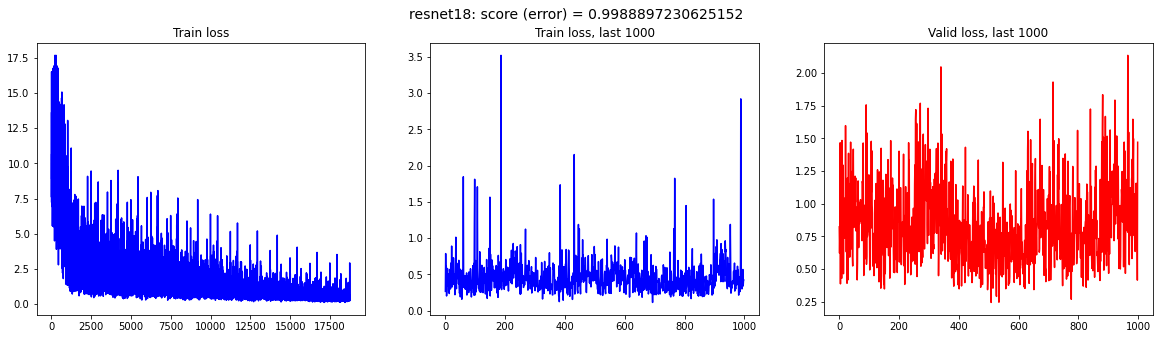

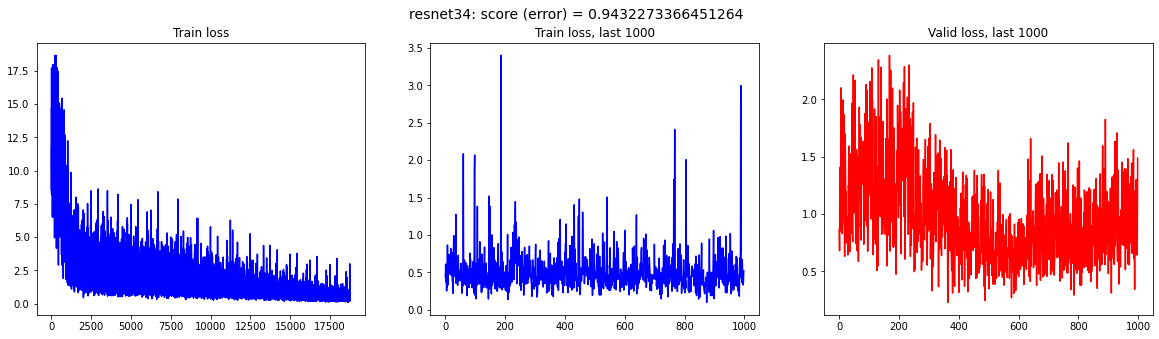

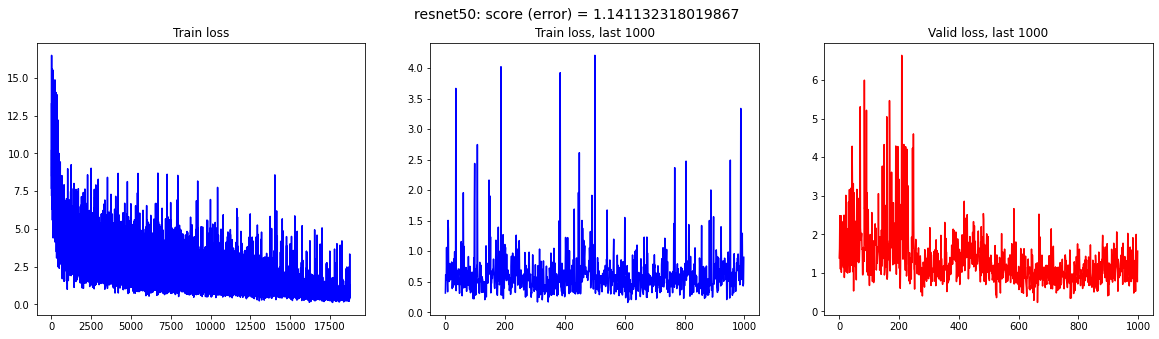

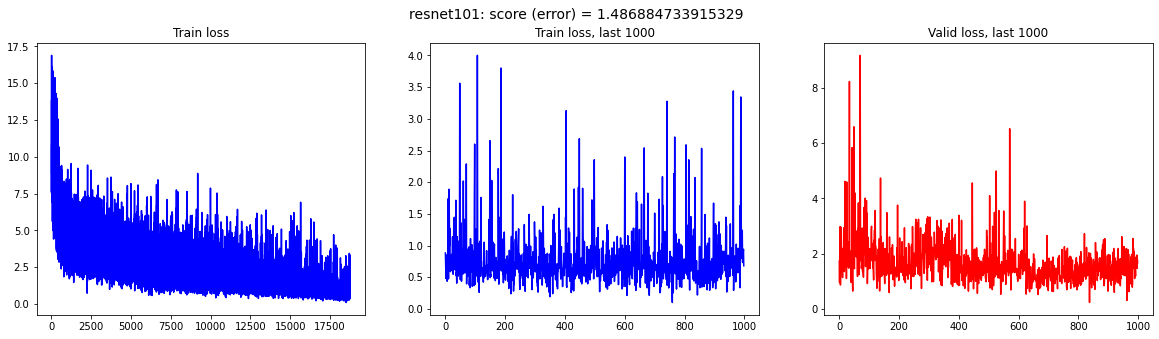

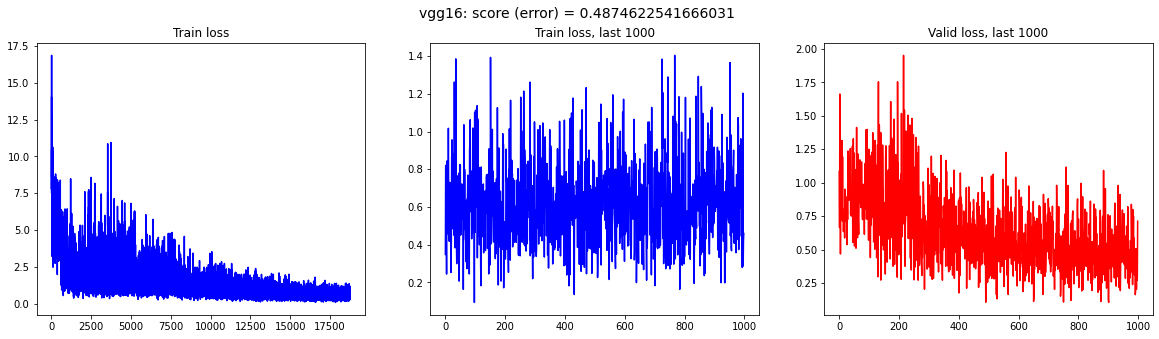

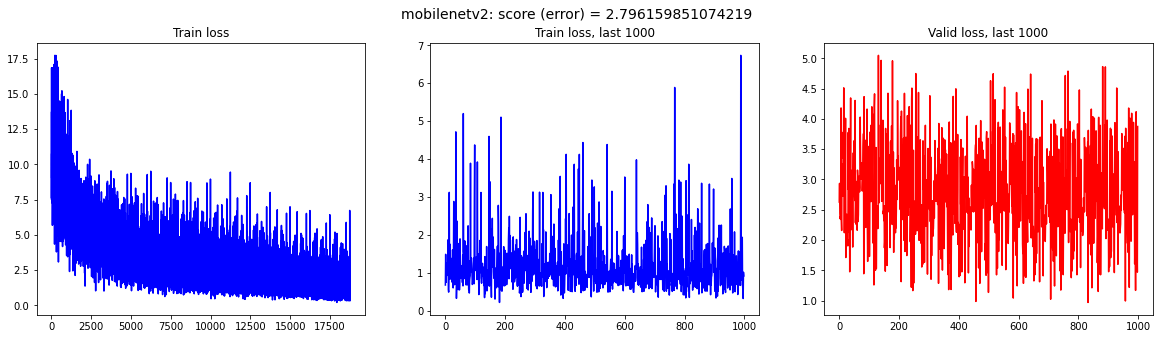

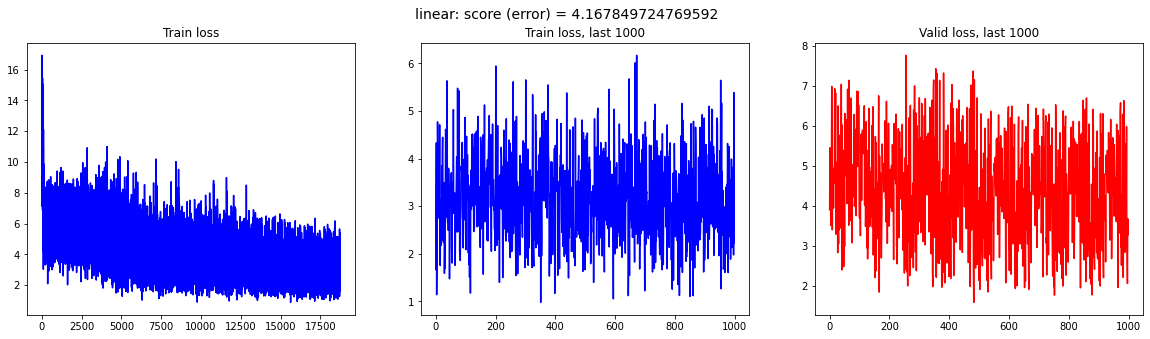

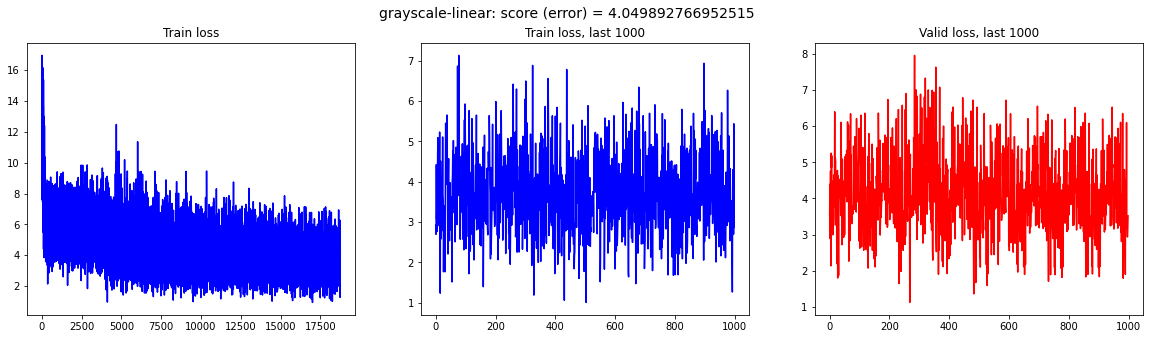

In [ ]:
for _, res in results.iterrows():
    visualize(res['name'], res['train_loss'], res['valid_loss'], res['mae'])

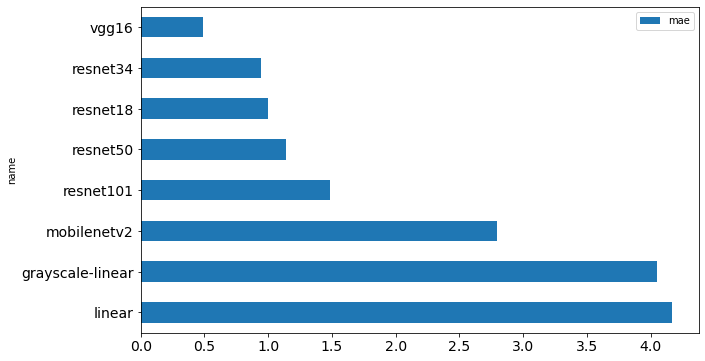

In [ ]:
results.sort_values('mae', ascending=False, inplace=True)
results.plot(x='name', y='mae', style='o', kind='barh', figsize=(10,6), fontsize=14) ;

# Additional training

Non-pretrained ResNet101 was chosen for further training on 40 epochs. Let's see if it shows higher results than VGG-16

In [ ]:
resnet101 = torchvision.models.resnet101()
resnet101.fc = nn.Linear(in_features=2048, out_features=1)
lt, lv = train(resnet101, 40)

In [ ]:
#torch.save(resnet101.state_dict(), '/content/drive/MyDrive/resnet101-dotcounter.pth')

# Results


## Per-patch regression
Model Mean Absolute Error for individual patch is ~0.85, which is close to rounding error.

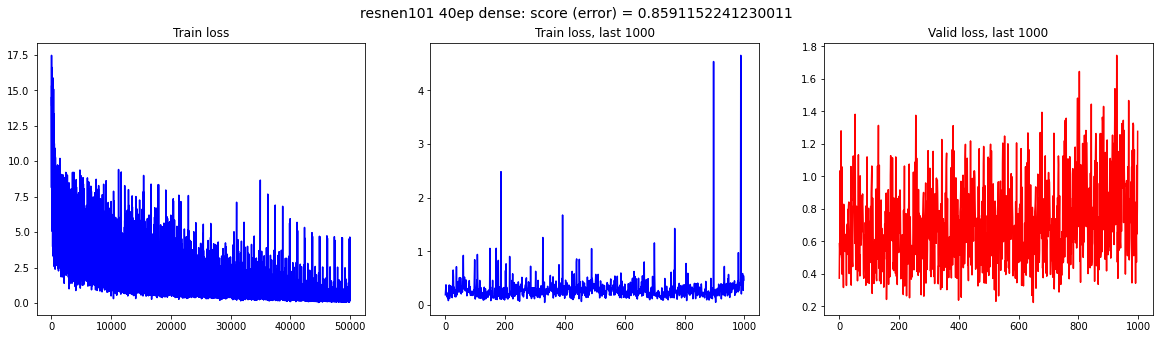

In [ ]:
visualize('resnen101 40ep dense', lt, lv, score(resnet101))

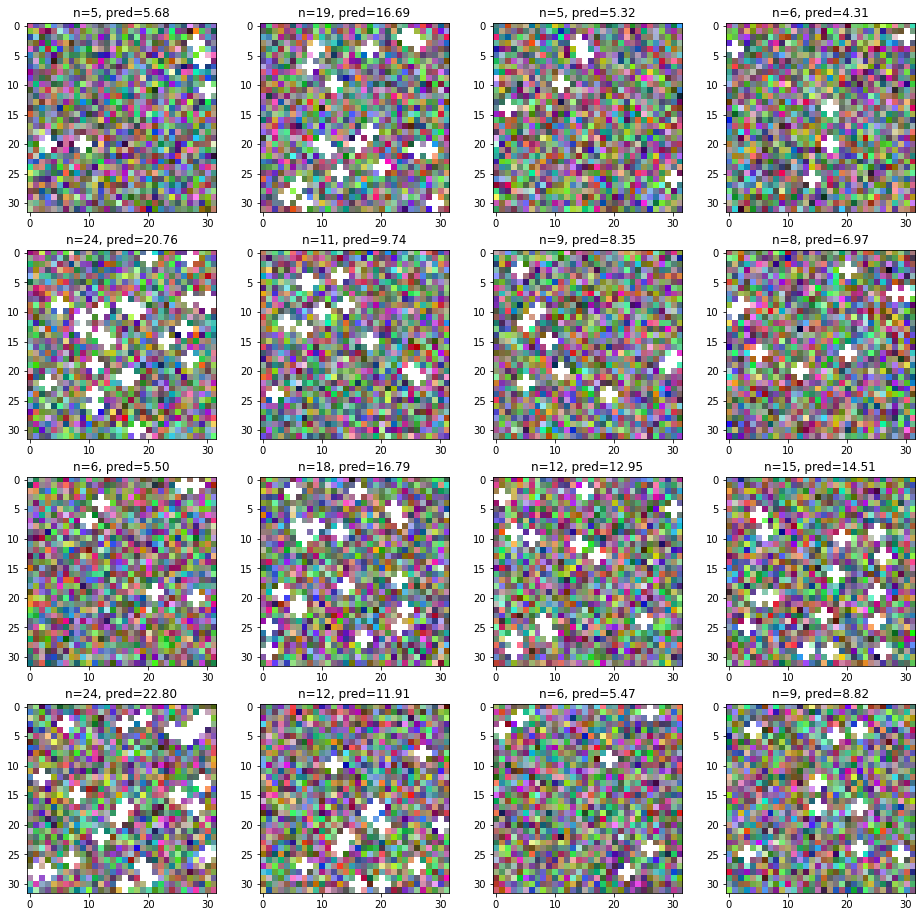

In [ ]:
plt.figure(figsize=(16,16))
for i in range(16):
    s = np.random.choice(len(images))
    plt.subplot(4,4,1+i)
    visualize_sample(resnet101)

## Heatmap integration

Heatmap is generated by sliding a window with it's side equal to the training patch resolution over the big panoramic image. Offset is a devisor of window size.

Overlapping predictions for individual patches produces the heatmap. Number of overlaps per pixel is determined by $\frac {window\ size} {offset}$ ratio.


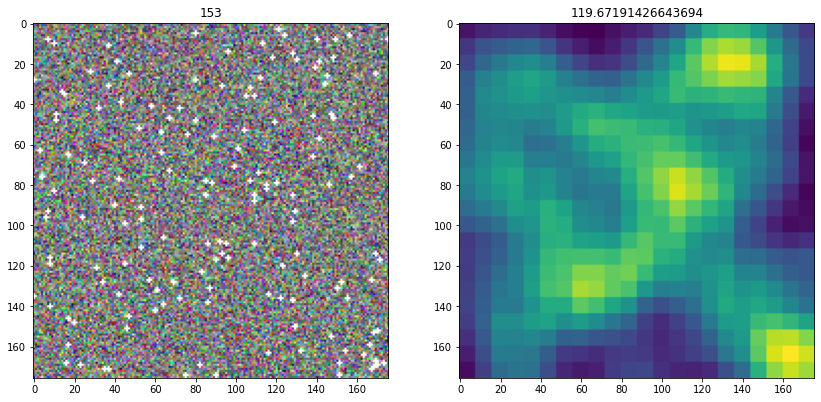

In [ ]:
visualize_heatmap(resnet101)

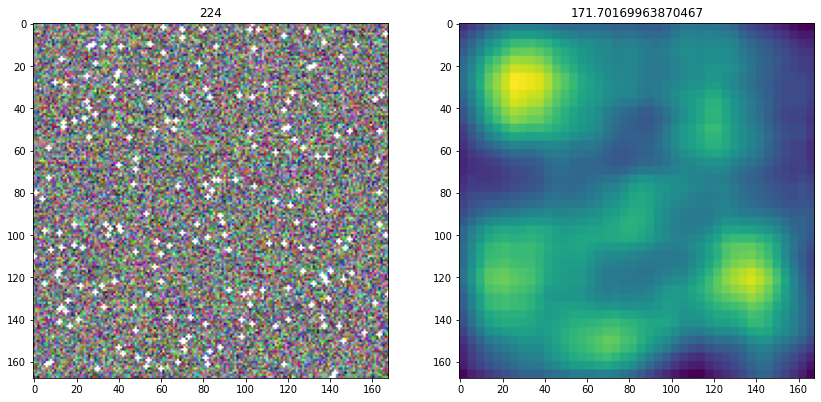

In [ ]:
visualize_heatmap(resnet101, offset=4)

## The integration error is constant

Heatmap integration results in a constant error, which can be easily corrected by adding $+C$ corrective to the integral.

In [ ]:
true = []
pred = []

for _ in range(50):
    pano, l = generate_pano()
    hmap = heatmap(pano, resnet101)

    pred.append(hmap.sum())
    true.append(l)

true, pred = map(np.array, (true, pred))

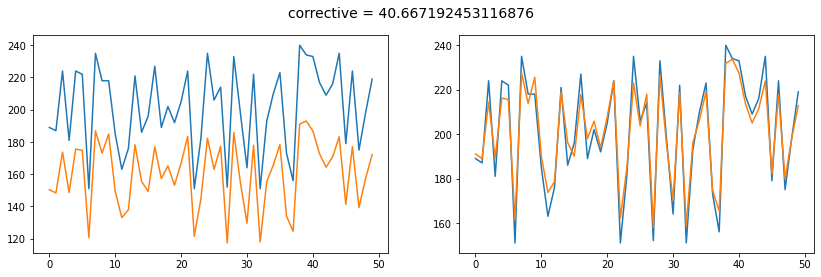

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(true)
plt.plot(pred)
corrective = (true - pred).mean()

plt.subplot(122)
plt.plot(true)
plt.plot(pred + corrective)

plt.suptitle(f"corrective = {corrective}", fontsize=14)
plt.show()

## Corrected predictions are highly accurate

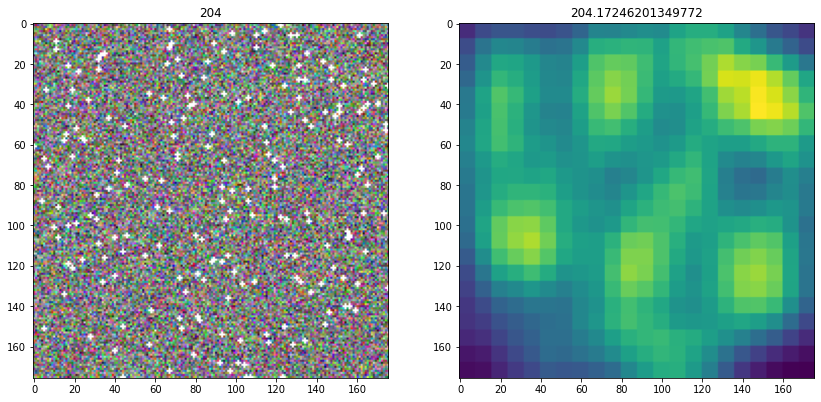

In [ ]:
visualize_heatmap(resnet101, corrective=corrective)

# Consusions
- Itegration over the sliding window heatmap is highly effective for regression-based object counting.
- Out of all non-pretrained models tested, VGG-16 was the most effective.
- ResNet101 did not beat VGG16 after 40 epoch training.

# Bonus
Training resnet for 40 more epochs with slightly lower LR yielded better results, but it was worse than VGG.

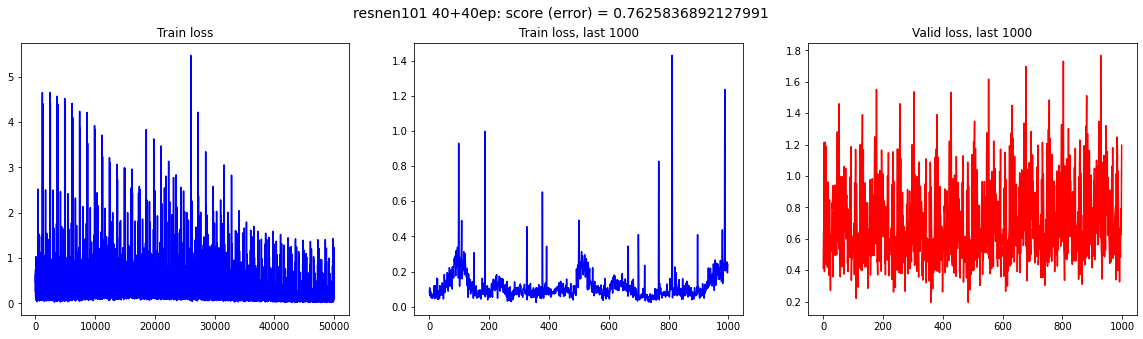

In [ ]:
lt, lv = train(resnet101, 40, 5e-5)
visualize('resnen101 40+40ep', lt, lv, score(resnet101))

Nikolay Grushetskiy,\
2021.08.13